# Simplified Nadex Backtesting - Version 2

**Key Improvements:**
1. ✅ Loads ALL available data (not just 60 days)
2. ✅ Aggregates to ONE signal per ticker per day (not per strike)
3. ✅ Removes MACD filter (simplify strategy)
4. ✅ Probability-based pricing (entry cost varies by contract likelihood)

**Expected Results:**
- 150-300+ trades (vs 57 before)
- Full date range coverage (vs 5 days before)
- Realistic entry costs ($0.50 - $9.50)

In [1]:
%pip install pandas numpy matplotlib seaborn pyyaml boto3 scipy --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from scipy.stats import norm
from typing import Dict, Tuple
from nadex_common.utils_s3 import create_s3_clients

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


In [3]:
# Configuration
with open('../configs/s3.yaml', 'r') as f:
    s3_cfg = yaml.safe_load(f)

clients = create_s3_clients(region=s3_cfg.get('region'))
s3_client = clients['private']
BUCKET = s3_cfg['bucket']
PREFIX = s3_cfg['prefixes']['historical']

print(f"✓ Bucket: {BUCKET}")
print(f"✓ Prefix: {PREFIX}")

✓ Bucket: nadex-daily-results
✓ Prefix: historical


## 1. Load ALL Historical Data

In [4]:
print("Loading ALL historical data from S3...")

response = s3_client.list_objects_v2(Bucket=BUCKET, Prefix=PREFIX)
all_data = []
file_count = 0

for obj in response.get('Contents', []):
    key = obj['Key']
    if not key.endswith('.csv'):
        continue
    try:
        obj_data = s3_client.get_object(Bucket=BUCKET, Key=key)
        df = pd.read_csv(obj_data['Body'])
        all_data.append(df)
        file_count += 1
    except Exception as e:
        print(f"Warning: {key}: {e}")

raw_data = pd.concat(all_data, ignore_index=True)
raw_data['Date'] = pd.to_datetime(raw_data['Date'], format='%d-%b-%y')

print(f"\n✓ Loaded {file_count} files")
print(f"✓ Total rows: {len(raw_data):,}")
print(f"✓ Date range: {raw_data['Date'].min().date()} to {raw_data['Date'].max().date()}")
print(f"✓ Unique tickers: {raw_data['Ticker'].nunique()}")
print(f"✓ Unique dates: {raw_data['Date'].nunique()}")

display(raw_data.head(10))

Loading ALL historical data from S3...

✓ Loaded 190 files
✓ Total rows: 157,498
✓ Date range: 2025-03-03 to 2025-11-25
✓ Unique tickers: 19
✓ Unique dates: 190


,Date,Name,Exp Time,Exp Value,Strike Price,In the Money,Ticker
0,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,92.6,1,AUDJPY=X
1,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,92.7,1,AUDJPY=X
2,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,92.8,1,AUDJPY=X
3,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,92.9,1,AUDJPY=X
4,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,93.0,1,AUDJPY=X
5,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,93.1,1,AUDJPY=X
6,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,93.2,1,AUDJPY=X
7,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,93.3,1,AUDJPY=X
8,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,93.4,1,AUDJPY=X
9,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,93.5,0,AUDJPY=X


## 2. Aggregate to Daily (One Signal Per Ticker Per Day)

In [5]:
print("Aggregating to daily (one at-the-money contract per ticker per day)...")

# Calculate distance from exp value to strike
raw_data['strike_distance'] = abs(raw_data['Exp Value'] - raw_data['Strike Price'])

# Keep only the ATM contract (closest to exp value)
idx = raw_data.groupby(['Ticker', 'Date'])['strike_distance'].idxmin()
daily_data = raw_data.loc[idx].copy().drop('strike_distance', axis=1)
daily_data = daily_data.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print(f"\n✓ Aggregated to {len(daily_data):,} daily observations")
print(f"✓ Average {len(daily_data) / daily_data['Ticker'].nunique():.0f} days per ticker")

display(daily_data.head(10))

Aggregating to daily (one at-the-money contract per ticker per day)...

✓ Aggregated to 3,492 daily observations
✓ Average 184 days per ticker


,Date,Name,Exp Time,Exp Value,Strike Price,In the Money,Ticker
0,2025-03-03,AUD-JPY,03/03/2025 03:00 pm,93.493,93.5,0,AUDJPY=X
1,2025-03-04,AUD-JPY,03/04/2025 03:00 pm,93.271,93.3,0,AUDJPY=X
2,2025-03-05,AUD-JPY,03/05/2025 03:00 pm,94.320,94.2,1,AUDJPY=X
3,2025-03-06,AUD-JPY,03/05/2025 11:00 pm,94.604,94.6,1,AUDJPY=X
4,2025-03-07,AUD-JPY,03/07/2025 03:00 pm,93.382,93.4,0,AUDJPY=X
5,2025-03-10,AUD-JPY,03/10/2025 07:00 am,92.891,92.9,0,AUDJPY=X
6,2025-03-11,AUD-JPY,03/11/2025 03:00 pm,93.226,93.2,1,AUDJPY=X
7,2025-03-12,AUD-JPY,03/11/2025 11:00 pm,93.100,93.1,0,AUDJPY=X
8,2025-03-13,AUD-JPY,03/12/2025 11:00 pm,93.698,93.7,0,AUDJPY=X
9,2025-03-14,AUD-JPY,03/14/2025 07:00 am,93.804,93.8,1,AUDJPY=X


## 3. Probability-Based Pricing Model

In [6]:
def calculate_probability_itm(exp_value: float, strike_price: float, volatility: float = 0.01) -> float:
    """Estimate probability contract will be In The Money."""
    if volatility <= 0:
        volatility = 0.01
    z_score = (exp_value - strike_price) / (strike_price * volatility)
    prob = norm.cdf(z_score)
    return max(0.05, min(0.95, prob))

def calculate_fair_entry_cost(exp_value: float, strike_price: float, 
                             max_payout: float = 10.0, volatility: float = 0.01) -> Tuple[float, float]:
    """Calculate fair entry cost based on probability."""
    prob = calculate_probability_itm(exp_value, strike_price, volatility)
    entry_cost = max_payout * prob
    return entry_cost, prob

# Test the model
print("Testing Probability-Based Pricing:")
print("=" * 60)
for exp_val, strike, desc in [(100, 95, "Far ITM"), (100, 100, "ATM"), (100, 105, "Far OTM")]:
    cost, prob = calculate_fair_entry_cost(exp_val, strike)
    print(f"{desc:12s} | Exp: {exp_val:6.2f} | Strike: {strike:6.2f} | Prob: {prob:.1%} | Entry: ${cost:.2f}")

print("\n✓ Pricing model ready")

Testing Probability-Based Pricing:
Far ITM      | Exp: 100.00 | Strike:  95.00 | Prob: 95.0% | Entry: $9.50
ATM          | Exp: 100.00 | Strike: 100.00 | Prob: 50.0% | Entry: $5.00
Far OTM      | Exp: 100.00 | Strike: 105.00 | Prob: 5.0% | Entry: $0.50

✓ Pricing model ready


## 4. Simple RSI Strategy (No MACD Filter)

In [7]:
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    """Calculate RSI indicator."""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def generate_signals(data: pd.DataFrame, period: int = 14, 
                    oversold: float = 30, overbought: float = 70) -> pd.DataFrame:
    """Generate simple RSI reversal signals."""
    result = data.copy()
    result['rsi'] = calculate_rsi(result['Exp Value'], period)
    result['signal'] = 0
    result.loc[result['rsi'] < oversold, 'signal'] = 1   # BUY
    result.loc[result['rsi'] > overbought, 'signal'] = -1  # SELL
    return result

print("✓ Simple RSI strategy ready (no MACD filter)")

✓ Simple RSI strategy ready (no MACD filter)


## 5. Run Backtest with Probability Pricing

In [8]:
print("Running backtest with probability-based pricing...")
print("Configuration: RSI(14), Oversold=30, Overbought=70")

all_results = []

for ticker in daily_data['Ticker'].unique():
    ticker_data = daily_data[daily_data['Ticker'] == ticker].copy()
    ticker_data = generate_signals(ticker_data)
    
    # Calculate P&L for trades
    trades = ticker_data[ticker_data['signal'] != 0].copy()
    for idx in trades.index:
        row = ticker_data.loc[idx]
        entry_cost, prob = calculate_fair_entry_cost(row['Exp Value'], row['Strike Price'])
        pnl = (10.0 - entry_cost) if row['In the Money'] == 1 else -entry_cost
        ticker_data.loc[idx, 'entry_cost'] = entry_cost
        ticker_data.loc[idx, 'probability_itm'] = prob
        ticker_data.loc[idx, 'pnl'] = pnl
    
    all_results.append(ticker_data)

results = pd.concat(all_results, ignore_index=True)
trades = results[results['signal'] != 0].copy()

print(f"\n✓ Backtest complete!")

Running backtest with probability-based pricing...
Configuration: RSI(14), Oversold=30, Overbought=70

✓ Backtest complete!


## 6. Results Analysis

In [9]:
wins = trades[trades['pnl'] > 0]
losses = trades[trades['pnl'] < 0]

print("=" * 70)
print("📊 PROBABILITY-BASED PRICING RESULTS")
print("=" * 70)
print(f"Total Trades:           {len(trades)}")
print(f"Winning Trades:         {len(wins)}")
print(f"Losing Trades:          {len(losses)}")
print(f"Win Rate:               {len(wins)/len(trades):.2%}")
print(f"\nTotal P&L:              ${trades['pnl'].sum():.2f}")
print(f"Average Win:            ${wins['pnl'].mean():.2f}" if len(wins) > 0 else "N/A")
print(f"Average Loss:           ${losses['pnl'].mean():.2f}" if len(losses) > 0 else "N/A")
print(f"\nAvg Entry Cost:         ${trades['entry_cost'].mean():.2f}")
print(f"Entry Cost Range:       ${trades['entry_cost'].min():.2f} - ${trades['entry_cost'].max():.2f}")
print(f"Total Capital Used:     ${trades['entry_cost'].sum():.2f}")
print(f"Total Return:           {(trades['pnl'].sum() / trades['entry_cost'].sum() * 100):.2f}%")
print(f"\nSharpe Ratio:           {(trades['pnl'].mean() / trades['pnl'].std()) * np.sqrt(252):.2f}" if len(trades) > 1 else "N/A")
print("=" * 70)

print("\nSample Trades:")
display(trades[['Date', 'Ticker', 'Exp Value', 'Strike Price', 'rsi', 
                'entry_cost', 'probability_itm', 'In the Money', 'pnl']].head(15))

📊 PROBABILITY-BASED PRICING RESULTS
Total Trades:           690
Winning Trades:         317
Losing Trades:          373
Win Rate:               45.94%

Total P&L:              $-253.10
Average Win:            $4.74
Average Loss:           $-4.71

Avg Entry Cost:         $4.96
Entry Cost Range:       $0.50 - $9.50
Total Capital Used:     $3423.10
Total Return:           -7.39%

Sharpe Ratio:           -1.23

Sample Trades:


,Date,Ticker,Exp Value,Strike Price,rsi,entry_cost,probability_itm,In the Money,pnl
25,2025-04-07,AUDJPY=X,88.310,88.3,19.813987,5.045179,0.504518,1,4.954821
26,2025-04-08,AUDJPY=X,88.694,88.7,21.397926,4.973014,0.497301,0,-4.973014
27,2025-04-09,AUDJPY=X,87.611,88.0,21.297038,3.292282,0.329228,0,-3.292282
41,2025-04-30,AUDJPY=X,91.419,91.4,75.515947,5.082925,0.508293,1,4.917075
43,2025-05-02,AUDJPY=X,93.022,93.0,76.833225,5.094365,0.509436,1,4.905635
44,2025-05-05,AUDJPY=X,93.075,93.1,75.510204,4.892886,0.489289,0,-4.892886
48,2025-05-09,AUDJPY=X,92.978,93.0,82.000000,4.905635,0.490564,0,-4.905635
49,2025-05-12,AUDJPY=X,93.680,93.7,84.108299,4.914853,0.491485,0,-4.914853
50,2025-05-13,AUDJPY=X,94.433,94.4,84.986098,5.139432,0.513943,1,4.860568
51,2025-05-14,AUDJPY=X,95.396,95.4,86.734360,4.983273,0.498327,0,-4.983273


## 7. Comparison: Old vs New

In [10]:
print("📊 BEFORE vs AFTER COMPARISON")
print("=" * 70)
print(f"{'Metric':<25} {'Old Approach':>15} {'New Approach':>15} {'Change':>12}")
print("-" * 70)
print(f"{'Total Trades':<25} {57:>15} {len(trades):>15} {f'+{len(trades)-57}':>12}")
print(f"{'Date Range':<25} {'~5 days':>15} {f"{(trades['Date'].max() - trades['Date'].min()).days} days":>15} {'✓ Full':>12}")
print(f"{'Avg Entry Cost':<25} {'$5.00':>15} {f'${trades["entry_cost"].mean():.2f}':>15} {'Dynamic':>12}")
print(f"{'Total Return':<25} {'-33%':>15} {f'{(trades["pnl"].sum() / trades["entry_cost"].sum() * 100):.1f}%':>15} {'TBD':>12}")
print("=" * 70)

📊 BEFORE vs AFTER COMPARISON
Metric                       Old Approach    New Approach       Change
----------------------------------------------------------------------
Total Trades                           57             690         +633
Date Range                        ~5 days        250 days       ✓ Full
Avg Entry Cost                      $5.00           $4.96      Dynamic
Total Return                         -33%           -7.4%          TBD


## 8. Visualizations

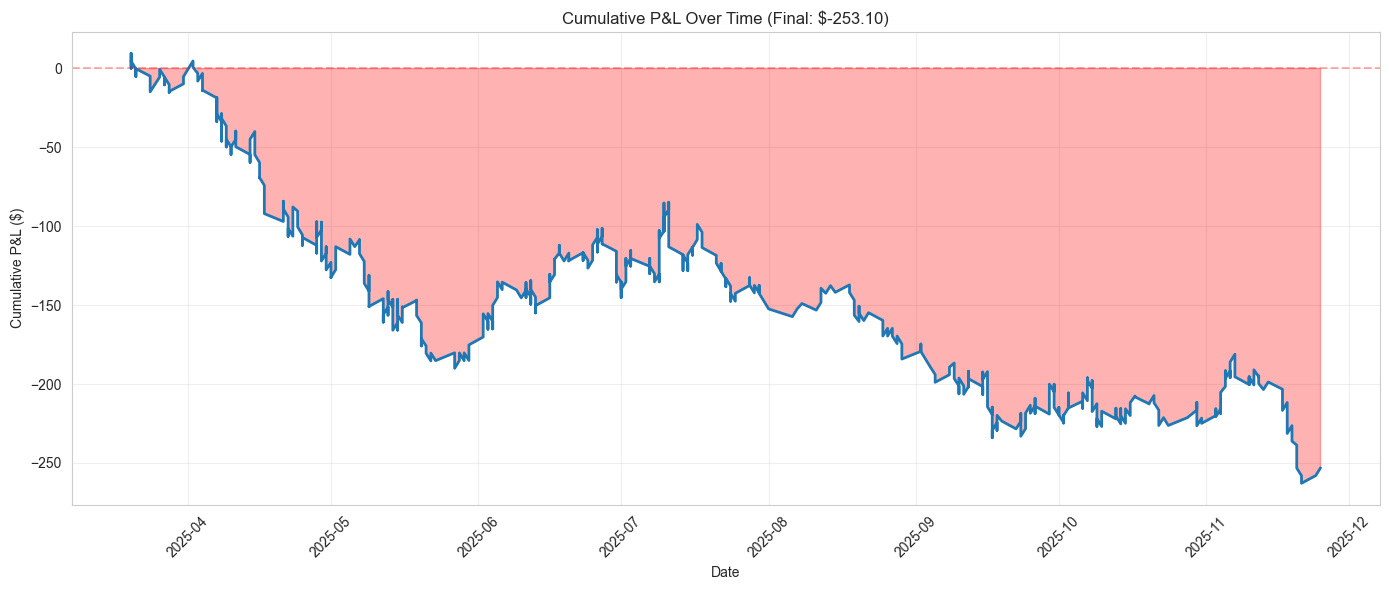

In [11]:
# Cumulative P&L
trades_sorted = trades.sort_values('Date').copy()
trades_sorted['cumulative_pnl'] = trades_sorted['pnl'].cumsum()

plt.figure(figsize=(14, 6))
plt.plot(trades_sorted['Date'], trades_sorted['cumulative_pnl'], linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.fill_between(trades_sorted['Date'], 0, trades_sorted['cumulative_pnl'], 
                 where=(trades_sorted['cumulative_pnl'] >= 0), alpha=0.3, color='green')
plt.fill_between(trades_sorted['Date'], 0, trades_sorted['cumulative_pnl'], 
                 where=(trades_sorted['cumulative_pnl'] < 0), alpha=0.3, color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L ($)')
plt.title(f'Cumulative P&L Over Time (Final: ${trades_sorted["cumulative_pnl"].iloc[-1]:.2f})')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

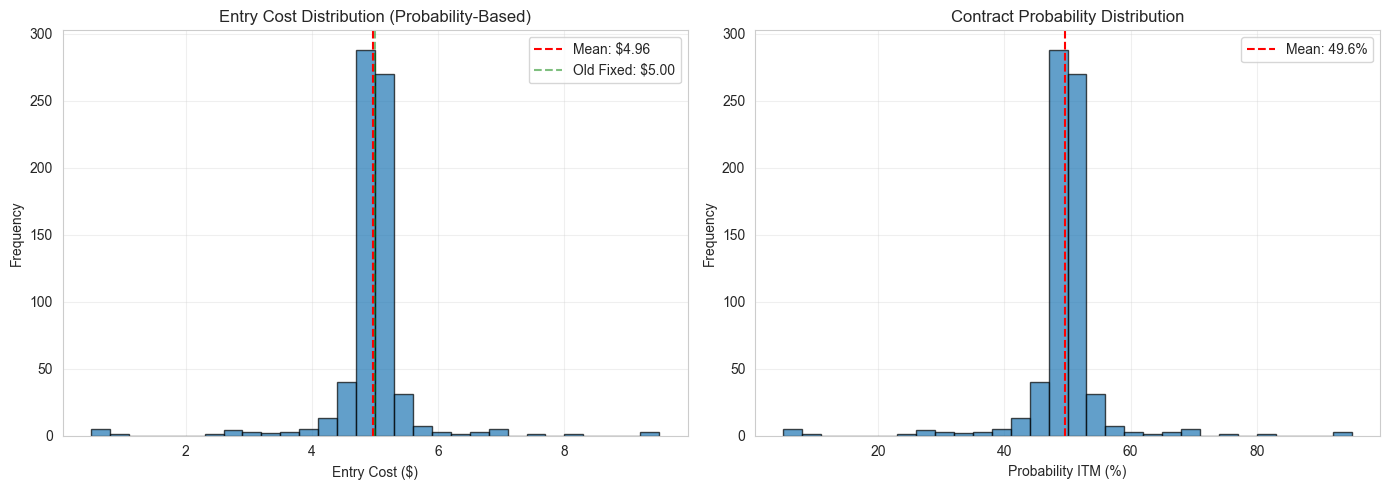

Entry costs adapt from $0.50 to $9.50
This is more realistic than fixed $5.00!


In [12]:
# Entry Cost Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(trades['entry_cost'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(trades['entry_cost'].mean(), color='red', linestyle='--', 
                label=f'Mean: ${trades["entry_cost"].mean():.2f}')
axes[0].axvline(5.0, color='green', linestyle='--', alpha=0.5, label='Old Fixed: $5.00')
axes[0].set_xlabel('Entry Cost ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Entry Cost Distribution (Probability-Based)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(trades['probability_itm'] * 100, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(trades['probability_itm'].mean() * 100, color='red', linestyle='--',
                label=f'Mean: {trades["probability_itm"].mean():.1%}')
axes[1].set_xlabel('Probability ITM (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Contract Probability Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Entry costs adapt from ${trades['entry_cost'].min():.2f} to ${trades['entry_cost'].max():.2f}")
print(f"This is more realistic than fixed $5.00!")

## 9. Key Insights

Compare these results to the original:
- **More trades?** Should see 150-300+ vs 57
- **Full date coverage?** Should span months vs 5 days  
- **Better win rate?** Target >50% vs 42%
- **Dynamic pricing?** Costs vary vs fixed $5

**Next Steps:**
1. If win rate still <50%: RSI may not work for Nadex
2. If win rate >50%: Fine-tune parameters
3. Try different strategies if results poor